# DQN

I have implemented a variant of deep Q-network, with replay-memory, a target network and a 2 layer neural network. Epsilon decreases linearly.
For some reason it doesn't really keep up the learning, this could either be due to incorrect hyperparameters or that there is some bug in the code. Something that might help is using clipping on the gradients. 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn import svm
import math
import tensorflow as tf
%matplotlib inline

In [2]:
class RandomAgent:
    def __init__(self, env, num_experiments=10, num_episodes=100, num_timesteps=1000):
        self.env = env
        self.num_experiments=num_experiments
        self.num_episodes=num_episodes
        self.num_timesteps=num_timesteps
    def getAction(self, state):
        return self.env.action_space.sample()
    def getQValue(self, state):
        pass
    def update(self, state, action, reward, nextState):
        pass
    def run(self):
        episodic_return = np.zeros((self.num_experiments, self.num_episodes))
        for i in range(self.num_experiments):
            for j in range(self.num_episodes):
                acc_reward = 0
                for t in range(self.num_timesteps):
                    observation = self.env.reset()
                    action = self.getAction(observation)
                    nextObservation, reward, done, info = self.env.step(action)
                    if done:
                        break
                    acc_reward += reward
                episodic_return[i, j] += acc_reward
        return episodic_return

In [5]:

class PGAgent:
    def __init__(self, env, num_experiments=10, num_episodes=100, num_timesteps=1000, 
                 replay_buffer_size=10000, epsilon=0.05, batch_size=32, lr=0.00001, target_step=1000):
        self.env = env
        self.num_experiments=num_experiments
        self.num_episodes=num_episodes
        self.num_timesteps=num_timesteps
        self.num_actions = 2
        self.replay_buffer_size = replay_buffer_size
        self.observation_size = self.env.observation_space.shape[0]
        self.epsilon = epsilon
        self.replay_buffer = []
        self.batch_size = batch_size
        self.lr = lr
        self.state = tf.placeholder(tf.float32, [None, self.observation_size], name="state")
        self.next_state = tf.placeholder(tf.float32, [None, self.observation_size], name="next_state")
        self.reward = tf.placeholder(tf.float32, [None], name="reward")
        self.action = tf.placeholder(tf.int32, [None], name="action")
        self.done = tf.placeholder(tf.float32, [None], name="action")
        self.target_step = target_step
        def network(input_data, scope):
            with tf.variable_scope(scope):
                w1 = tf.layers.dense(input_data, 64,  name="input_layer")
                #w2 = tf.layers.dense(w1, 32, name="h1")
                out = tf.layers.dense(w1, self.num_actions, name="h2")
            return out
        
        self.Q_network = network(self.state, "network")
        self.Q_target = network(self.next_state, "target")
        

        
        
        
        network_params = [t for t in tf.trainable_variables() if t.name.startswith("network")]
        network_params = sorted(network_params, key=lambda v: v.name)
        target_params = [t for t in tf.trainable_variables() if t.name.startswith("target")]
        target_params = sorted(target_params, key=lambda v: v.name)

        update_target = []
        for network_v, target_v in zip(network_params, target_params):
            op = target_v.assign(network_v)
            update_target.append(op)


                
        self.update_target_op = update_target

        #Using done as a float is very hacky
        self.loss = tf.reduce_mean(1/2*tf.pow(self.reward + (1.0-self.done)*tf.reduce_max(self.Q_target, axis=1) - tf.gather(self.Q_network, self.action, axis=1), 2))
        
        self.optim = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(self.loss)

        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())
        
    
        
    ### This method will return a sampled action
    ### from your policy
    def getAction(self, state, epsilon=0.05):
        Q = self.getQValues(state)
        action = []
        for q in Q:
            if random.random() < epsilon:
                action.append(random.choice(range(self.num_actions)))
            else:
                action.append(np.argmax(q))
        return action
        
    def getQValues(self, state):
        return self.session.run(self.Q_network, feed_dict= {self.state: state})
    
                
    def update_target(self):
        self.session.run(self.update_target_op)
        
    def update(self):
        state, action, reward, next_state,done = self.sample_from_buffer(size=self.batch_size)
        self.session.run(self.optim, feed_dict={
                self.state: state, self.action: action, self.reward: reward, self.next_state: next_state, self.done: done}
                )
       
    def add_replay_buffer(self,x):
        self.replay_buffer.append(x)
        if len(self.replay_buffer)>self.replay_buffer_size:
            self.replay_buffer = self.replay_buffer[-self.replay_buffer_size:]
            
    def sample_from_buffer(self, size=1):
        buffer_length = len(self.replay_buffer)
        sample = np.random.choice(buffer_length, size)
        reward = []
        state = []
        action = []
        next_state = []
        done = []
        for i in sample:
            s, a, r, n_s, d = self.replay_buffer[i]
            state.append(s)
            reward.append(r)
            action.append(a)
            next_state.append(n_s)
            done.append(d)
        
        return state, action, reward, next_state, done
        
    
    def step(self, action):
        nextObservation = []
        reward = []
        done = []
        for a in action:
            n_o, r, d, info = self.env.step(a)
            done.append(d)
            nextObservation.append(n_o)
            reward.append(r)
        return nextObservation, reward, done
            
    def epsilon_anneal(self, iteration, maximum=1., minimum=0.02):
        stop_anneal = 0.5*self.num_experiments*self.num_episodes
        if iteration > stop_anneal:
            return minimum
        else:
            return minimum + (maximum-minimum)*(1-iteration/stop_anneal)
        
    def run(self):
        episodic_return = np.zeros((self.num_experiments, self.num_episodes))
        total_steps=0
        for i in range(self.num_experiments):
            # first collect some MC returns 
            for j in range(self.num_episodes):
                acc_reward = 0
                observation = self.env.reset()
                for t in range(self.num_timesteps):
                    action = self.getAction(np.array([observation]), self.epsilon_anneal(total_steps))
                    action = action[0]
                    nextObservation, reward, done,  info = self.env.step(action)
                    self.add_replay_buffer((observation, action, reward, nextObservation, done*1.0))
                    acc_reward += reward
                    self.update()
                    total_steps+=1
                    if total_steps%self.target_step == 0:
                        self.update_target()
                    if done:
                        break
                    observation = nextObservation
                episodic_return[i, j] += acc_reward
                if j*25%self.num_episodes == 0 and j>0:
                    print(total_steps, np.mean(episodic_return[i,j-10:j]))
        return episodic_return
    

[2018-03-27 16:40:02,279] Making new env: CartPole-v0


1943 9.2
3458 13.6
5065 10.9
6767 11.3
8248 14.0
9647 11.0
11058 9.8
12394 12.8
13816 12.5
15186 10.2
16532 10.2
17953 12.2
19279 10.1
20589 11.0
21997 14.8
23292 11.5
24596 9.4
25940 15.6
27305 9.8
28744 12.2
30301 12.1
31686 10.0
33095 11.8
34392 10.4


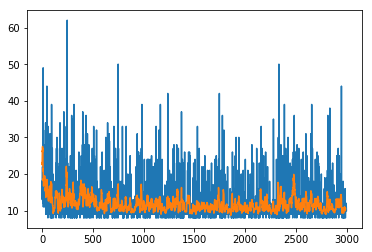

In [6]:
# pg agent
tf.reset_default_graph()
env = gym.make("CartPole-v0")
ragent = PGAgent(env, num_episodes=3000, num_experiments=1, num_timesteps=200, lr=0.01, batch_size=128, target_step=100)
eps_return = ragent.run()
#print (eps_return.shape)
#print (np.mean(eps_return, axis=0))
plt.plot(np.mean(eps_return, axis=0))
#plt.scatter()

cumsum_vec = np.cumsum(np.insert(np.mean(eps_return, axis=0), 0, 0)) 
ma_vec = (cumsum_vec[10:] - cumsum_vec[:-10]) / 10
plt.plot(ma_vec)

# random agent
#env = gym.make("CartPole-v0")
#ragent = RandomAgent(env)
#eps_return = ragent.run()
#print(np.mean(eps_return, axis=0))
